# 0. Importing pytorch and setting up device-agnostic code

In [1]:
import torch 
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data 

In [3]:
import requests
import zipfile
from pathlib import Path 

# Setup path to data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doen't exist, download it and prepare it 
if image_path.is_dir(): 
    print(f"{image_path} directory exists.")
    
else: 
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza_steak_sushi data...")
        f.write(request.content)
        
    # Unzip data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", r) as zip_ref: 
        print("Unzipping pizza_steak_sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


# 2. Become one with data(data preparation)

In [4]:
import os 

def walk_through_dir(dir_path): 
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2.1 Visualize an image

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image width: 512
Image height: 408


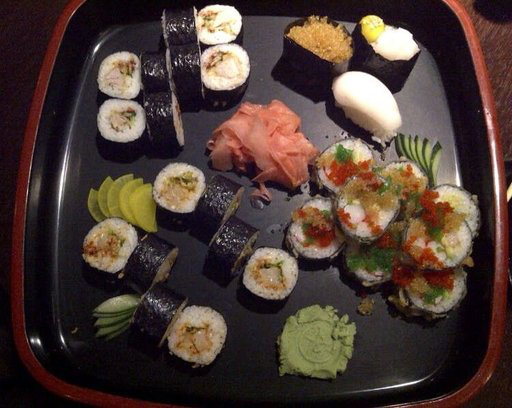

In [8]:
import random 
from PIL import Image

# Set seed 
random.seed(42)

# 1. Get all paths ending in "jpg"
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 511.5, 407.5, -0.5)

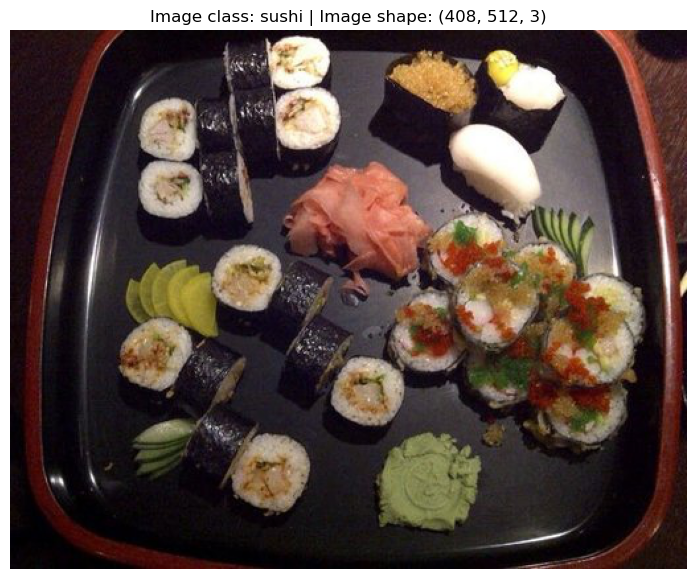

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 

# Turn the image into an array 
img_as_array = np.asarray(img)

# Plot the image with matplotlib 
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

# 3. Transforming data 

In [10]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with torchvision.transforms



In [11]:
# Write transform for image 
data_transform = transforms.Compose([
    # Resize the image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into Tensor
    transforms.ToTensor()
])


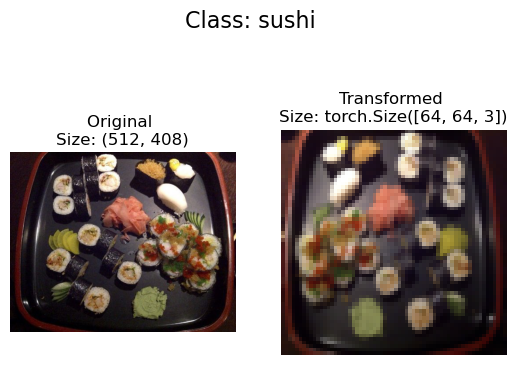

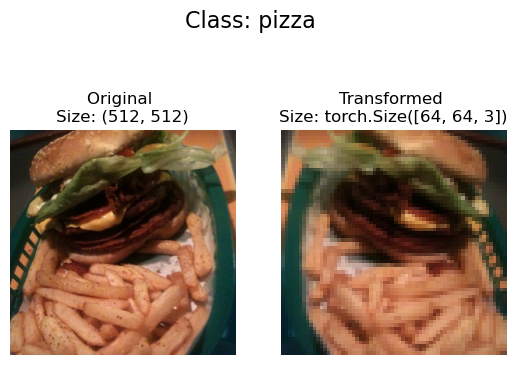

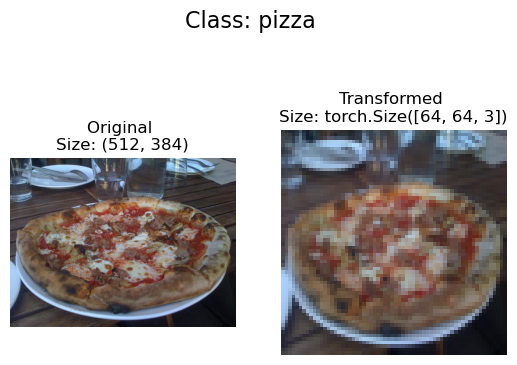

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(42)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot image 
            # Note: permute() will change the shape of image to suit matplotlib
            # torch: [C, H, W] but in matplotlib is [H, W, C]
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_path_list,
                        transform=data_transform, 
                        n=3)

# 4. Option 4: Loading Image Data Using `ImageFolder`

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


(-0.5, 63.5, 63.5, -0.5)

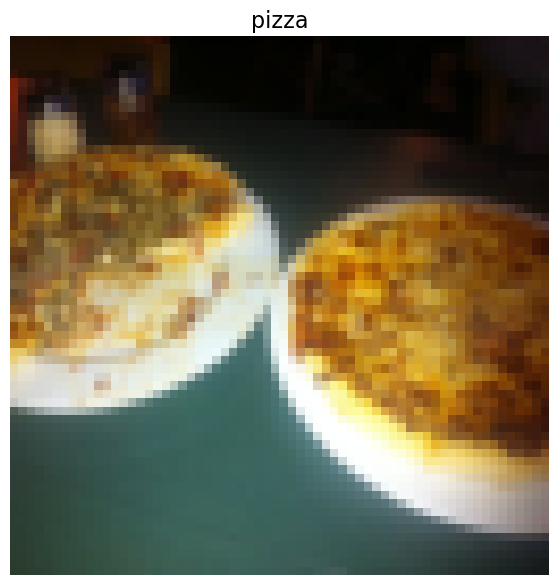

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label], fontsize=16)
plt.axis(False)

## 4.1 Turn loaded images into DataLoader's

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e4c41290d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e4c1d16010>)

In [20]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Option 2: Loading Image Data with a Custom dataset

In [21]:
import os 
import pathlib
import torch 

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict

## 5.1 Creating a helper function to get class names

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the classnames from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f"Class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes: 
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
        
    # 3. Create a dictionary of index labels
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom dataset to replicate ImageFolder

In [25]:
from torch.utils.data import Dataset

# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform(optional) paramemter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Set up tranforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__() method (optional)
    def __len__(self) -> int: 
        "Returns the total number of samples"
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label(X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform: 
            return self.transform(img), class_idx
        else: 
            return img, class_idx
        

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1e4c417e450>,
 <__main__.ImageFolderCustom at 0x1e4c4486950>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


## 5.3 Create a function to display random images

In [32]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True, 
                          seed: int = None):
    
    # Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
        
    # Set seed 
    if seed:
        random.seed(seed)
        
    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # Set plot
    plt.figure(figsize=(16, 8))
    
    # Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx): 
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # Adjust image tensor shape for plotting: [C, H, W] -> [H, W, C]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        
        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape: 
                title += f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)
        

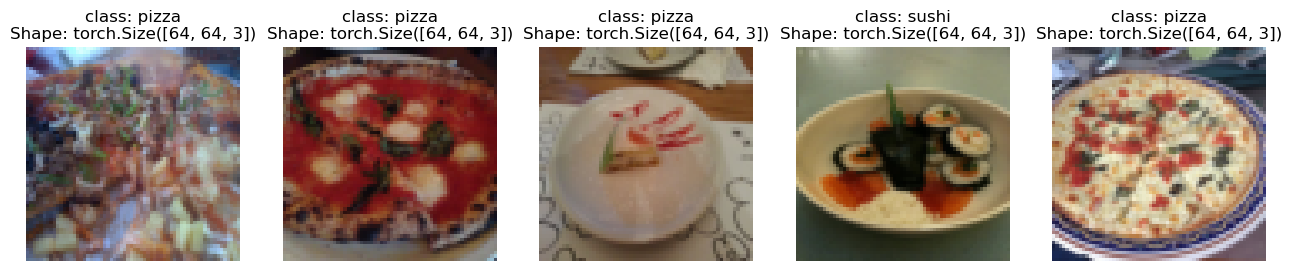

In [33]:
display_random_images(dataset=train_data_custom, 
                      classes=class_names,
                      n=5, 
                      seed=None)

# 5.4 Turn custom loaded images into `DataLoader`

In [34]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1, 
                                     num_workers=0,
                                     shuffle=True
                                    )

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1e4c4106c90>,
 <torch.utils.data.dataloader.DataLoader at 0x1e4c234c810>)

In [35]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 6. Other forms of transforms (data augmentation)

* The purpose of transform is to alter images in some way. -> referred to as `data augmentation`

* `Data augmentation` is the process of altering your data in such a way that you artificially increase the diversity of your training set.

In [36]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

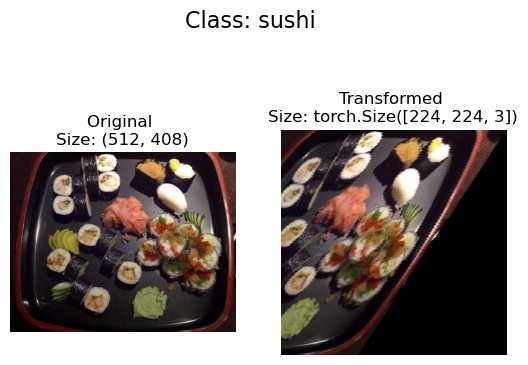

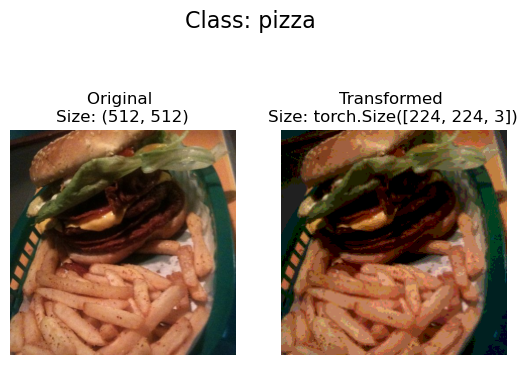

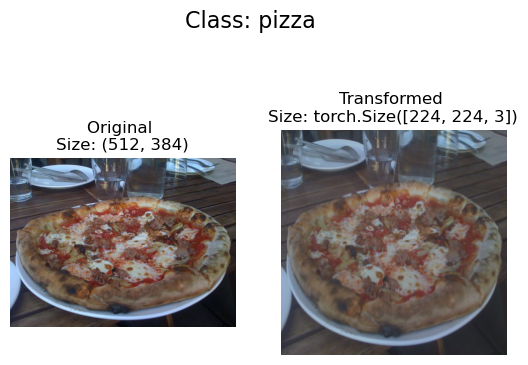

In [37]:
# get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# plot random images 
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

# 7. Model 0: Tiny VGG without data augmentation

## 7.1 Creating transforms and loading data for model 0

In [38]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [39]:
from torchvision import datasets 
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Turn data into dataloaders
import os 
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 20 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1e4c4636e50>,
 <torch.utils.data.dataloader.DataLoader at 0x1e4c4590990>)

## 7.2 Create TinyVGG model class

In [40]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor): 
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 7.3 Try a forward pass on a single image (to test the model)

In [41]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0352]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


## 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [42]:
try: 
    import torchinfo
except: 
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, 
        input_size=[1, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.5 Create train and test loops 

In [70]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [71]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 7.6 Creating a train() function to combine train_step & test_step

In [72]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer = nn.CrossEntropyLoss,
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # 6. Return the filled results at the end of the epochs
    return results


## 7.7 Train and Evaluate Model 0

In [73]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1696 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0955 | train_acc: 0.4141 | test_loss: 1.1384 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1428 | test_acc: 0.1979
Total training time: 55.812 seconds


In [74]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [75]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss value of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get the accuracy value of the results dictionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    
    # Setup a plot
    plt.figure(figsize=(15, 7))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

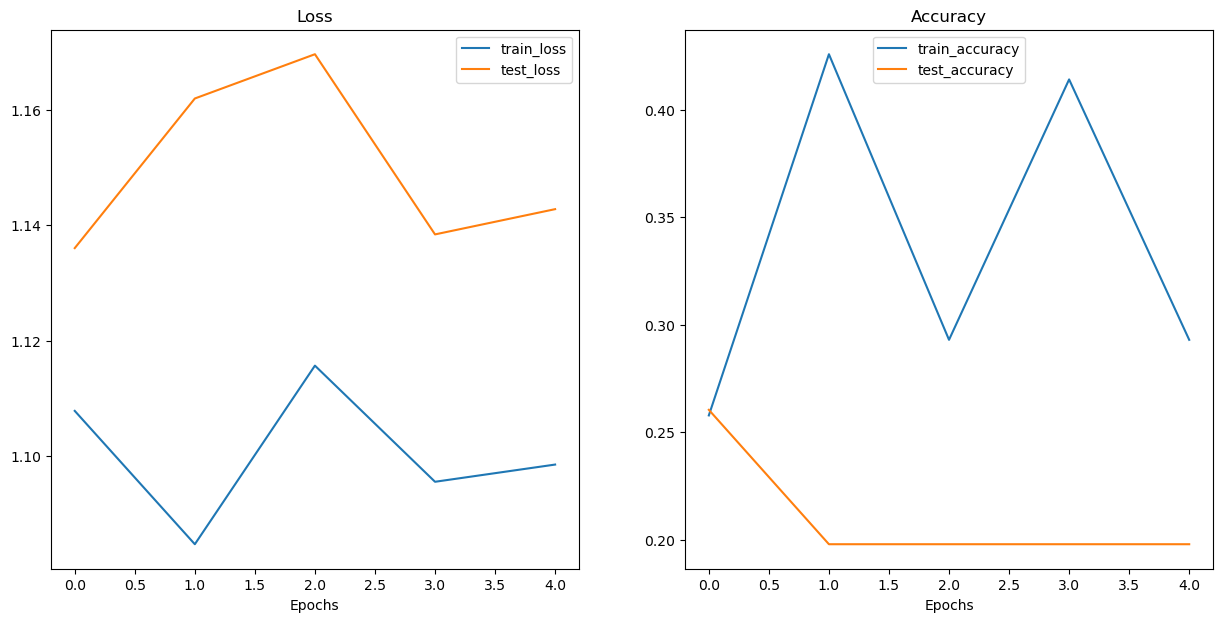

In [76]:
plot_loss_curves(model_0_results)

# 9. Model 1: TinyVGG with Data Augmentation

## 9.1 Create transform with data augmentation

In [78]:
# create training transform with trivialaugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

## 9.2 Create train and test dataset's and dataloader's

In [79]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [81]:
import os 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x1e5fcae0710>,
 <torch.utils.data.dataloader.DataLoader at 0x1e5fc8c3b90>)

## 9.3 Construct and train Model 1

In [84]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3, 
    hidden_units=10, 
    output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [85]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
NUM_EPOCHS = 5

# Set loss function and optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1058 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1382 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0803 | train_acc: 0.4258 | test_loss: 1.1685 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1285 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0880 | train_acc: 0.4258 | test_loss: 1.1473 | test_acc: 0.2604
Total training time: 56.712 seconds.


## 9.4 Plot the loss curves of Model 1

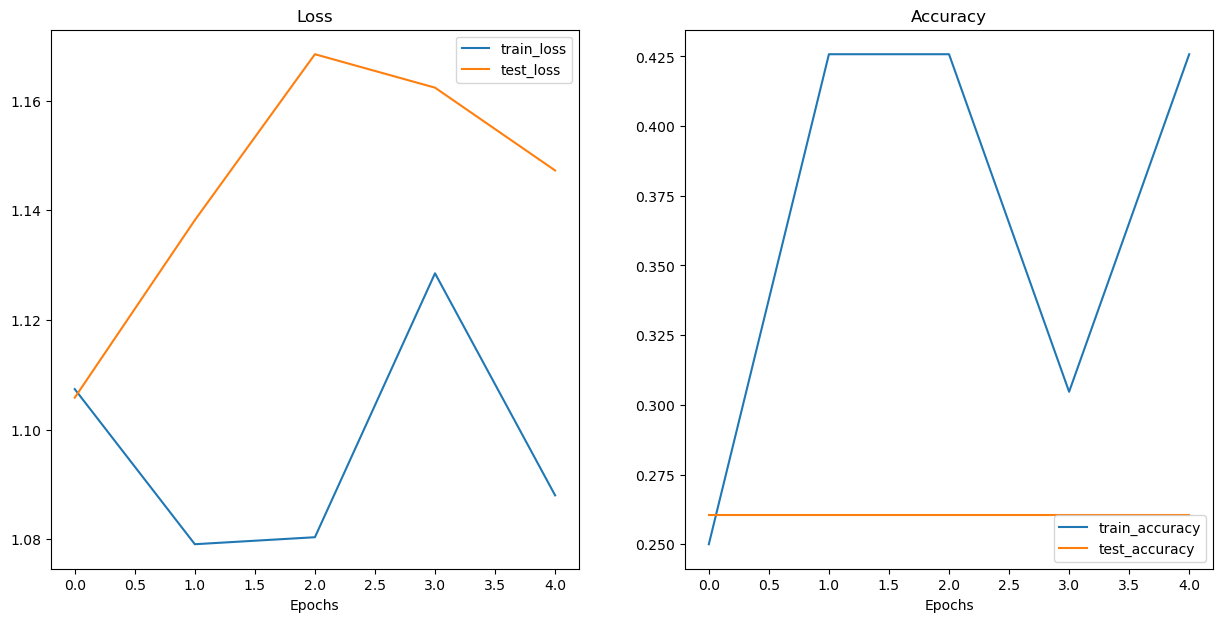

In [86]:
plot_loss_curves(model_1_results)

In [89]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_4000\2445833762.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084721,0.425781,1.161973,0.197917
2,1.115674,0.292969,1.169647,0.197917
3,1.095545,0.414062,1.138417,0.197917
4,1.098527,0.292969,1.142794,0.197917


In [88]:
!pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.6 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.3/11.6 MB 2.4 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.6 MB 3.7 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/11.6 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.2/11.6 MB 9.2 MB/s eta 0:00:02
   --------------- ------------------------ 4.4/11.6 MB 14.7 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.6 MB 18.2 MB/s eta 0:00:01
   --------------------------- ------------ 8.0/11.6 MB 21.3 MB/s eta 0:00:01
   ----------------------------- ---------- 8.5/11.6 MB 19.5 MB/s eta 0:00:01
   -------------------------------------- - 11.1/11.6 MB 32.7 MB/s eta 0:00:01
   ---------------------------------------  11.6/11.6 MB 32.7 MB/s eta 0:00:01
   --

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.1 requires joblib>=0.13.2, which is not installed.
mlxtend 0.23.1 requires scikit-learn>=1.0.2, which is not installed.
mlxtend 0.23.1 requires scipy>=1.2.1, which is not installed.


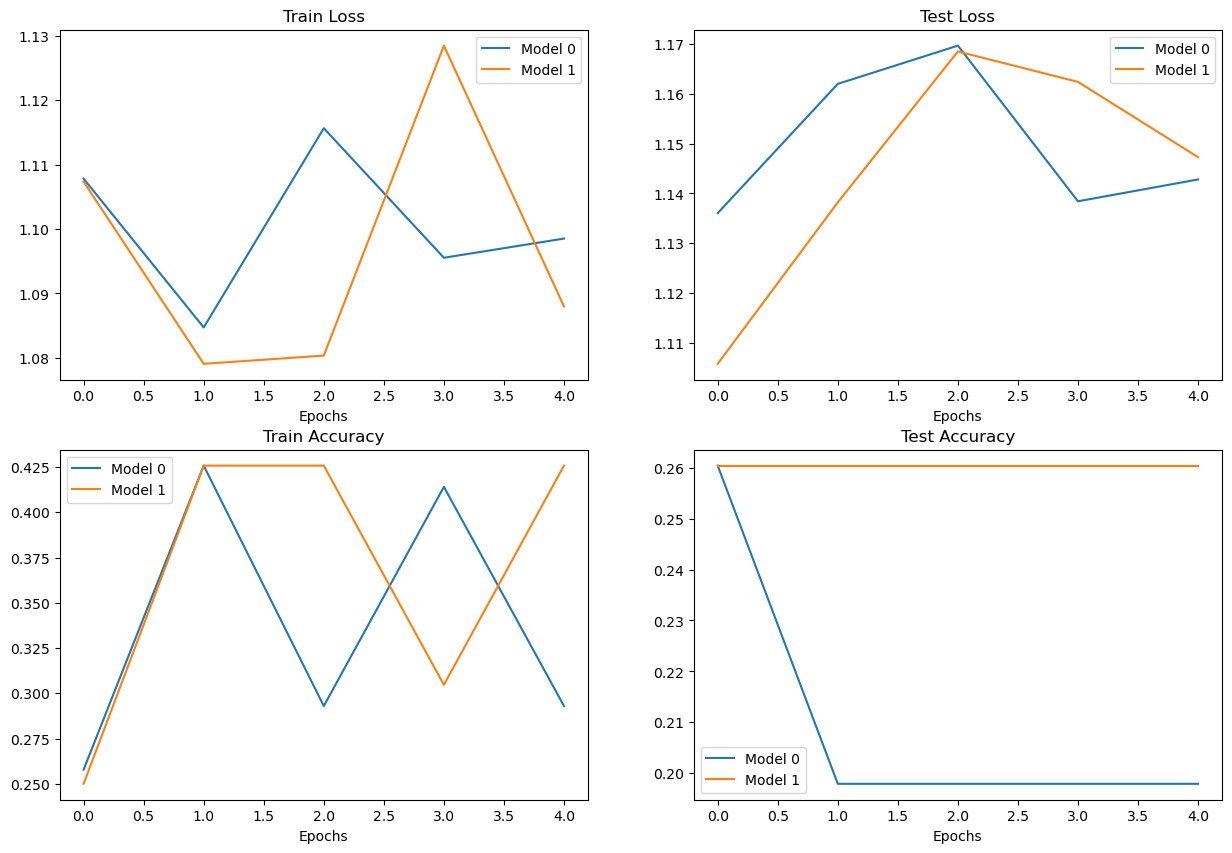

In [90]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# 11. Make prediction on a custom image

In [92]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it does not exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f: 
        # When downloading from Github, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
        
else: 
    print(f"{custom_image_path} already exists, skipping download.")

## 11.1 Loading in a custom image with pytorch

In [93]:
import torchvision

# Read in custom image 
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data 
print(f"Custom image tensor:\n{custom_image_unit8}\n")
print(f"Custom image shape: {custom_image_unit8.shape}\n")
print(f"Custom image datatype: {custom_image_unit8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dat

In [95]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255

# Print out the data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

## 11.2 Predicting on custom images with a trained pytorch model 

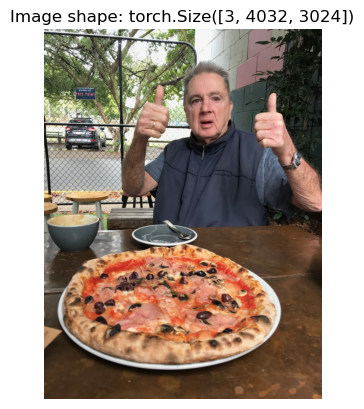

In [96]:
# Plot custom image 
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [98]:
# Create transform pipeline to resize image 
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [99]:
model_1.eval()
with torch.inference_mode(): 
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [100]:
custom_image_pred

tensor([[ 0.1170,  0.0162, -0.1426]], device='cuda:0')

In [101]:
# print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# convert logits -> prediction probabilites (torch.softmax() for multiclassification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# convert prediction probabilities -> prediction labels 
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1170,  0.0162, -0.1426]], device='cuda:0')
Prediction probabilities: tensor([[0.3738, 0.3379, 0.2883]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [106]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] 
# put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [107]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3738, 0.3379, 0.2883]], device='cuda:0')

## 11.3 Putting custom image prediction together: building a funtion`

In [110]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device=device):
    """Makes prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel by 255 to get them between [0, 1]
    target_image = target_image / 255
    
    # 3. Transform if necessary:
    if transform: 
        target_image = transform(target_image)
        
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation model and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
        
        # Make a prediction on image with an extra dimension and send it to target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> pred prob (using torch.softmax())
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # 7. Convert pred probs -> pred label (using torch.argmax())
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names: 
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Pro: {target_image_pred_probs.max().cpu():.3f}"
        
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        
    plt.title(title)
    plt.axis(False);

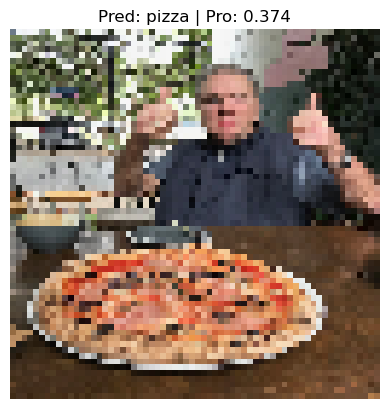

In [112]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)